## Tutorial for `Type3` problem

$$
\begin{aligned}
 \min_{\{u_t\}_{t=1}^{H}} &\, \sum_{t=1}^{t=H} (x_t-\bar x_t)Q(x_t-\bar x_t)^{T} + u_t R u_t^{T} \\
 \text{s.t.} &\, x_{t+1} = f_{\theta}(x_t, u_t) \, \forall t={1...H}\\
             &\, u_{min} \leq u_t \leq u_{max} \, \forall t={1...H}\\
\end{aligned}
$$

This type of problem is often invoked in MPC (Model predictive control)

In [1]:
from math import floor

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from src.LinearSimulator import Simulator, SimpleSSM
from src.ScipyMPC import MPC
from src.utils import set_seed
set_seed(seed=0, use_cuda=False)

## Setup model and simulator

In [2]:
state_dim = 2
action_dim = 3

model = SimpleSSM(state_dim, action_dim)
simul = Simulator(state_dim, action_dim)

A=np.array([[0.9, 0.1],
            [0.1,0.9]])

B=np.array([[1, -1],
            [-1, 2],
            [-2, 1]])

model.A.weight.data = torch.Tensor(A).float()
simul.A.weight.data = torch.Tensor(A).float()
model.B.weight.data = torch.Tensor(B).float()
simul.B.weight.data = torch.Tensor(B).float()

In [3]:
action_min = -1.0
action_max = 1.0
H = 5
T = 100

Q=torch.eye(state_dim) * 10
R=torch.eye(action_dim) * 0
r=torch.eye(action_dim)*0

x_ref = torch.ones((T, state_dim)) * 10
recession_period = floor(T * 0.2)
x_ref[:recession_period, :] = 0
x_ref[-recession_period:, :] = 0

In [4]:
solver = MPC(model, 
             state_dim, 
             action_dim, 
             H, 
             x_ref, 
             action_min, 
             action_max, 
             Q, R, r)

In [5]:
x = torch.zeros(1,state_dim)
state_trajectory = []
action_trajectory = []
opt_results = []

for itr in range(T-H):
    # Solve MPC problem
    state_ref = x_ref[itr:itr+H,:]
    solver.set_mpc_params(x,state_ref)
    opt_actions, pred_states, opt_result = solver.solve()    
    action = opt_actions[0]
    
    # perform simulation with the optmized action
    with torch.no_grad():
        x = simul(x,action.view(1,-1))
    
    action_trajectory.append(action.numpy())
    state_trajectory.append(x.numpy())
    opt_results.append(opt_result)

In [6]:
state_trajectory = np.stack(state_trajectory).squeeze()
action_trajectory = np.stack(action_trajectory).squeeze()

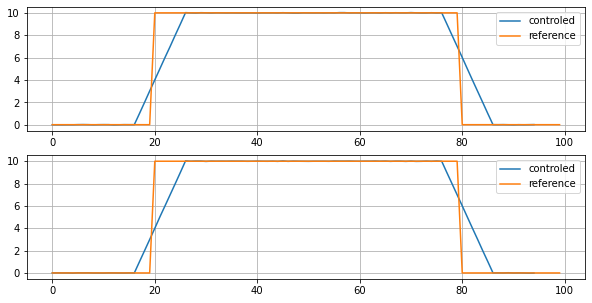

In [7]:
fig, axes = plt.subplots(state_dim,1, figsize=(10,5))
for i in range(state_dim):
    axes[i].grid()
    axes[i].plot(state_trajectory[:, i], label='controled')
    axes[i].plot(x_ref[:, i], label='reference')
    axes[i].legend()

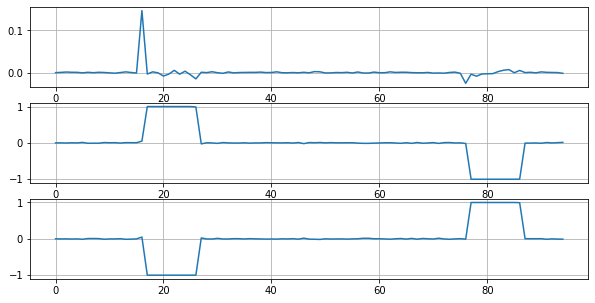

In [8]:
fig, axes = plt.subplots(action_dim,1, figsize=(10,5))
for i in range(action_dim):
    axes[i].grid()
    axes[i].plot(action_trajectory[:, i], label='actions')

## What if our model is not precise?

In MPC predictive performance, especially multi-step prediction with boostraping is essential. However, it is very unlikely in practice. To be precise, it is almost impossible to achieve perfect model of the true system (or plant). the impossibility may origin from several roots. For instance, our sensor measurements is always noisy up to certain level or due to the function approximation error of learning models.

The first class solution of this problem is alway to gather more clear and diverse data or improve the model. The improvement may includes the probabilitic estimator such as Kalman filters. However such methods may not be appropriate in the realistc settings. If the target systems is physical, we cannot operate the system of our own to collect more diverse data. Secondly, we may not able to execute MPC with the complex models due to the computational limitations.

Fortunately, MPC is relatively robust to the model errors on controlling the system. Let's see how the MPC output is sensitive to the errors in parameter estimation.

In [9]:
noise_level = 1e-2 * 5

model_corrupted = SimpleSSM(state_dim, action_dim)

A_corrupted = A + np.random.randn(state_dim, state_dim) * noise_level # add noise on paramters
B_corrupted = B + np.random.randn(action_dim, state_dim) * noise_level # add noise on paramters

model_corrupted.A.weight.data = torch.Tensor(A_corrupted).float()
model_corrupted.B.weight.data = torch.Tensor(B_corrupted).float()

In [10]:
H = 2

In [11]:
solver = MPC(model_corrupted, 
             state_dim, 
             action_dim, 
             H, 
             state_ref, 
             action_min, 
             action_max, 
             Q, R, r)

In [12]:
x = torch.zeros(1,state_dim)
state_trajectory = []
action_trajectory = []

for itr in range(T-H):
    # Solve MPC problem
    state_ref = x_ref[itr:itr+H,:]
    solver.set_mpc_params(x,state_ref)
    opt_actions, pred_states, opt_result = solver.solve()    
    action = opt_actions[0]
    
    # perform simulation with the optmized action
    with torch.no_grad():
        x = simul(x,action.view(1,-1))
    
    action_trajectory.append(action.numpy())
    state_trajectory.append(x.numpy())

In [13]:
state_trajectory = np.stack(state_trajectory).squeeze()
action_trajectory = np.stack(action_trajectory).squeeze()

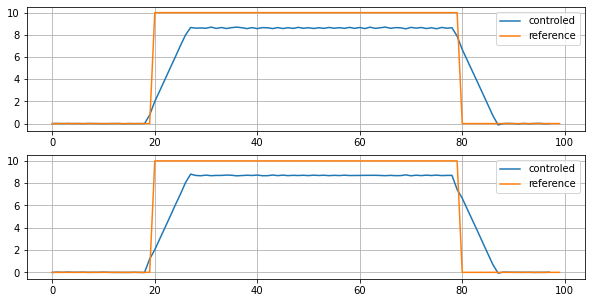

In [14]:
fig, axes = plt.subplots(state_dim,1, figsize=(10,5))
for i in range(state_dim):
    axes[i].grid()
    axes[i].plot(state_trajectory[:, i], label='controled')
    axes[i].plot(x_ref[:, i], label='reference')
    axes[i].legend()

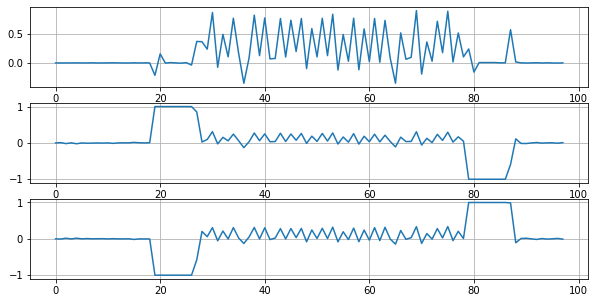

In [15]:
fig, axes = plt.subplots(action_dim,1, figsize=(10,5))
for i in range(action_dim):
    axes[i].grid()
    axes[i].plot(action_trajectory[:, i], label='actions')